## initialization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [ ]:
pd.set_option("display.max_columns", None)
data = pd.read_csv("Airline_Delay_Cause.csv")
data = data.dropna()
data.drop(['carrier_name','airport_name'], axis=1,inplace=True)

display(data.describe())
display(data)

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000
mean,2019.478604,6.488411,328.263244,58.709086,18.598619,2.038589,17.118839,0.145511,20.807539,6.827555,0.780545,3868.713998,1327.400141,209.405898,821.096086,6.849508,1503.955406
std,2.412093,3.464885,931.575550,164.378035,47.417686,6.899212,56.315314,0.702619,64.953490,41.471159,3.492814,11909.596123,4070.328372,792.332527,3180.677510,40.467958,4881.265039
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,6.000000,1.970000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,290.000000,91.000000,0.000000,28.000000,0.000000,55.000000
50%,2020.000000,6.000000,89.000000,15.000000,5.420000,0.220000,3.310000,0.000000,4.300000,1.000000,0.000000,903.000000,322.000000,12.000000,124.000000,0.000000,287.000000
75%,2022.000000,10.000000,218.000000,40.000000,14.730000,1.630000,9.880000,0.000000,13.040000,3.000000,1.000000,2552.000000,988.000000,131.000000,401.500000,0.000000,966.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,160.000000,438783.000000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,ABE,72.0,5.0,2.46,1.00,0.73,0.00,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,AEX,62.0,7.0,4.25,0.00,1.00,0.00,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,AGS,95.0,10.0,5.94,0.00,1.06,0.00,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,ALB,23.0,2.0,0.56,0.00,0.00,0.00,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,ATL,2111.0,256.0,76.88,8.75,52.43,0.00,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179333,2015,1,WN,ONT,892.0,184.0,59.21,2.61,22.41,0.98,98.79,3.0,2.0,8431.0,2661.0,123.0,1029.0,92.0,4526.0
179334,2015,1,WN,ORF,151.0,45.0,18.00,2.01,7.19,0.00,17.80,0.0,0.0,2391.0,840.0,295.0,301.0,0.0,955.0
179335,2015,1,WN,PBI,251.0,68.0,25.17,0.08,14.92,0.00,27.83,6.0,0.0,3405.0,1003.0,9.0,534.0,0.0,1859.0
179336,2015,1,WN,PDX,793.0,173.0,64.00,1.27,21.12,0.00,86.60,0.0,1.0,7479.0,2370.0,143.0,689.0,0.0,4277.0


# Transformation of data

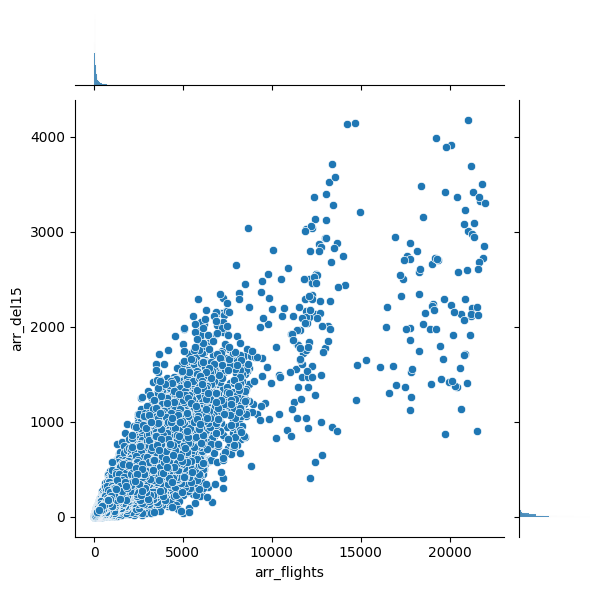

In [51]:
sns.jointplot(data=data,x='arr_flights',y='arr_del15')

In [102]:
# normalized data per arrival flight
dataNormalized = data.copy()
delay_cols = data.loc[:,'arr_del15':'late_aircraft_delay']
delay_cols = delay_cols.div(data['arr_flights'], axis=0)
dataNormalized.loc[:,'arr_del15':'late_aircraft_delay'] = delay_cols
display(dataNormalized.describe())
dataNormalized.head()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000
mean,2019.478604,6.488411,328.263244,0.180415,0.066410,0.007914,0.047885,0.000437,0.057771,0.024430,0.002828,11.853812,4.543490,0.869718,2.086403,0.020493,4.333676
std,2.412093,3.464885,931.575550,0.114585,0.061919,0.019386,0.053291,0.003305,0.056878,0.062520,0.010860,15.332149,11.409709,5.528583,3.241804,0.231675,5.821951
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,0.105263,0.032222,0.000000,0.013646,0.000000,0.017964,0.000000,0.000000,5.157895,1.523167,0.000000,0.464286,0.000000,0.844064
50%,2020.000000,6.000000,89.000000,0.166667,0.055741,0.001273,0.036350,0.000000,0.047500,0.003922,0.000000,9.528967,3.146509,0.069930,1.328463,0.000000,2.988067
75%,2022.000000,10.000000,218.000000,0.238018,0.086964,0.009890,0.065968,0.000000,0.082935,0.024590,0.000447,15.530931,5.580869,0.725337,2.663043,0.000000,5.930233
max,2023.000000,12.000000,21977.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.988095,0.666667,3174.000000,3166.000000,1244.000000,403.000000,43.000000,418.000000


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,ABE,72.0,0.069444,0.034167,0.013889,0.010139,0.0,0.011250,0.000000,0.0,9.333333,0.847222,7.972222,0.277778,0.0,0.236111
1,2023,12,9E,AEX,62.0,0.112903,0.068548,0.000000,0.016129,0.0,0.028226,0.000000,0.0,5.612903,4.064516,0.000000,0.532258,0.0,1.016129
2,2023,12,9E,AGS,95.0,0.105263,0.062526,0.000000,0.011158,0.0,0.031579,0.000000,0.0,9.042105,5.642105,0.000000,0.494737,0.0,2.905263
3,2023,12,9E,ALB,23.0,0.086957,0.024348,0.000000,0.000000,0.0,0.062609,0.043478,0.0,3.260870,0.391304,0.000000,0.000000,0.0,2.869565
4,2023,12,9E,ATL,2111.0,0.121270,0.036419,0.004145,0.024837,0.0,0.055869,0.000474,0.0,10.148745,4.218854,0.346755,0.704405,0.0,4.878730


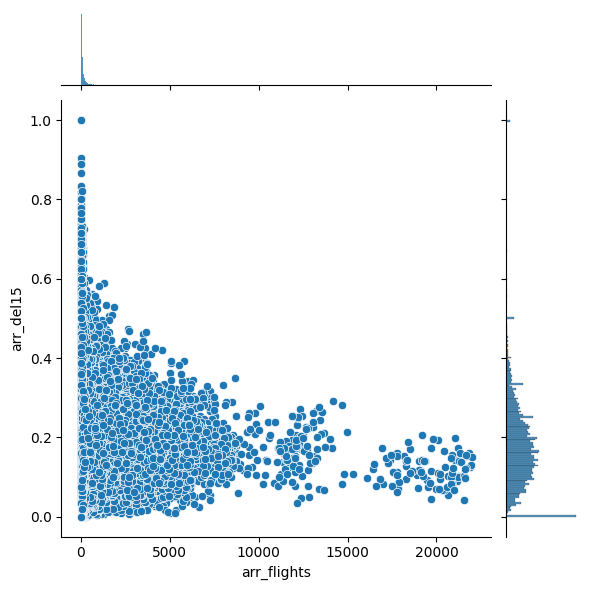

In [74]:
sns.jointplot(data=dataNormalized,x='arr_flights', y='arr_del15')

In [103]:
# removing data points with less number of arrival flights 
cutoff = 10
print (f"percent of data points with arrival flights less than or equal to {cutoff} :{sum(dataNormalized['arr_flights']<=cutoff)/len(dataNormalized)*100}")
dataNormalized = dataNormalized.iloc[[i for i,x in enumerate(dataNormalized['arr_flights'] > cutoff) if x],:]
dataNormalized.describe()

percent of data points with arrival flights less than or equal to 10 :6.6278035435559755


,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000,166900.000000
mean,2019.443919,6.502097,351.211090,0.180075,0.065763,0.007848,0.047756,0.000441,0.058267,0.024109,0.002841,11.725218,4.419092,0.846511,2.086993,0.020394,4.352193
std,2.426509,3.463837,959.941869,0.097862,0.047257,0.013581,0.044465,0.002698,0.048551,0.058469,0.009043,9.116524,4.630414,2.553826,2.602447,0.181406,4.692995
min,2015.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,53.000000,0.110368,0.034483,0.000000,0.016818,0.000000,0.022222,0.000000,0.000000,5.552741,1.718750,0.000000,0.569892,0.000000,1.113693
50%,2019.000000,7.000000,95.000000,0.168000,0.057116,0.002065,0.037873,0.000000,0.049737,0.005647,0.000000,9.750000,3.258691,0.117188,1.391304,0.000000,3.175791
75%,2022.000000,10.000000,237.000000,0.235632,0.086705,0.010588,0.066439,0.000000,0.083422,0.026059,0.001050,15.560000,5.630160,0.786667,2.690732,0.000000,6.029672
max,2023.000000,12.000000,21977.000000,0.903226,0.785714,0.304615,0.571562,0.171818,0.626667,0.988095,0.609195,173.375000,168.472222,133.000000,103.166667,26.325581,101.400000


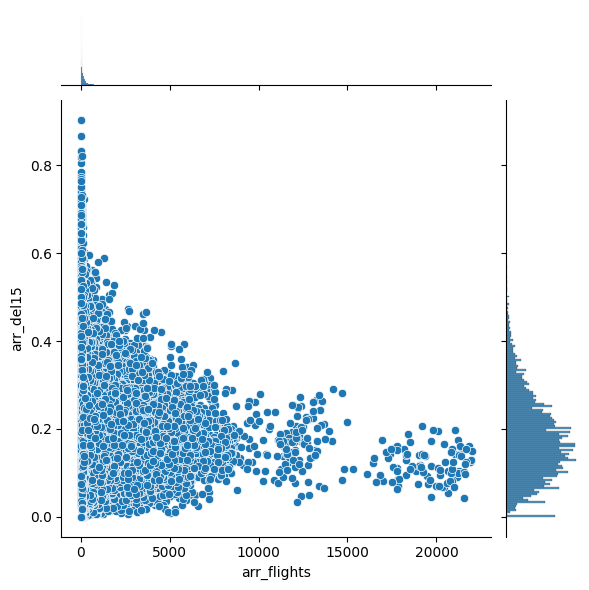

In [104]:
sns.jointplot(data=dataNormalized,x='arr_flights', y='arr_del15')

# EDA

<Axes: xlabel='arr_delay', ylabel='Count'>

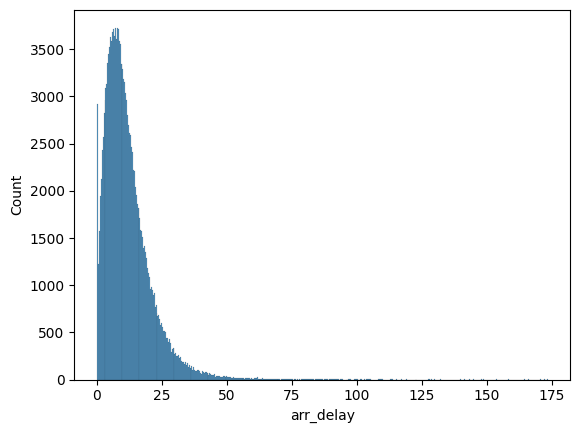

In [85]:
sns.histplot(data=dataNormalized, x = 'arr_delay')
# plt.hist()

In [105]:
# linear correlation 
dataNormalized.drop(['carrier','airport'],axis=1).corr()

# strong correlation between arr_del15 and cause of delay is obv except security delay which is low showing that expectedly security issues are rare and independent of number of arrival flights
# strong corr of X_delay with X_ct other than arr_del15 and ar_delay 

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,0.001306,-0.045296,0.017513,0.104532,0.050726,-0.054312,0.041788,-0.033215,0.038023,-0.008493,0.053325,0.087942,0.049574,-0.043611,0.030559,0.012839
month,0.001306,1.000000,0.004099,-0.033801,-0.011007,-0.037209,-0.040158,0.004727,-0.010498,-0.158731,-0.011154,-0.028082,-0.008282,-0.022385,-0.040527,0.002908,-0.011831
arr_flights,-0.045296,0.004099,1.000000,-0.004594,-0.070605,-0.044186,0.036175,0.000313,0.038668,-0.020793,-0.018766,0.002400,-0.029754,-0.029922,0.058313,0.000938,0.017931
arr_del15,0.017513,-0.033801,-0.004594,1.000000,0.672794,0.265732,0.597554,0.098212,0.733712,-0.042434,0.027561,0.776706,0.502378,0.153234,0.520310,0.074885,0.638319
carrier_ct,0.104532,-0.011007,-0.070605,0.672794,1.000000,0.110807,0.069942,0.073514,0.283629,-0.055920,0.007607,0.526445,0.686633,0.066780,0.080590,0.060967,0.261803
weather_ct,0.050726,-0.037209,-0.044186,0.265732,0.110807,1.000000,0.076708,0.026100,0.076342,0.010879,0.056150,0.305444,0.109995,0.611818,0.099026,0.030279,0.095803
nas_ct,-0.054312,-0.040158,0.036175,0.597554,0.069942,0.076708,1.000000,0.043118,0.196674,-0.020974,0.040080,0.373940,0.072884,0.030710,0.806805,0.025128,0.189400
security_ct,0.041788,0.004727,0.000313,0.098212,0.073514,0.026100,0.043118,1.000000,0.024039,-0.011342,0.011099,0.051639,0.038858,0.009991,0.041382,0.696210,0.006678
late_aircraft_ct,-0.033215,-0.010498,0.038668,0.733712,0.283629,0.076342,0.196674,0.024039,1.000000,-0.014312,-0.004878,0.622348,0.244598,0.044045,0.201399,0.021417,0.831144
arr_cancelled,0.038023,-0.158731,-0.020793,-0.042434,-0.055920,0.010879,-0.020974,-0.011342,-0.014312,1.000000,0.040586,0.006628,-0.012429,0.013904,0.015416,-0.005823,0.009244


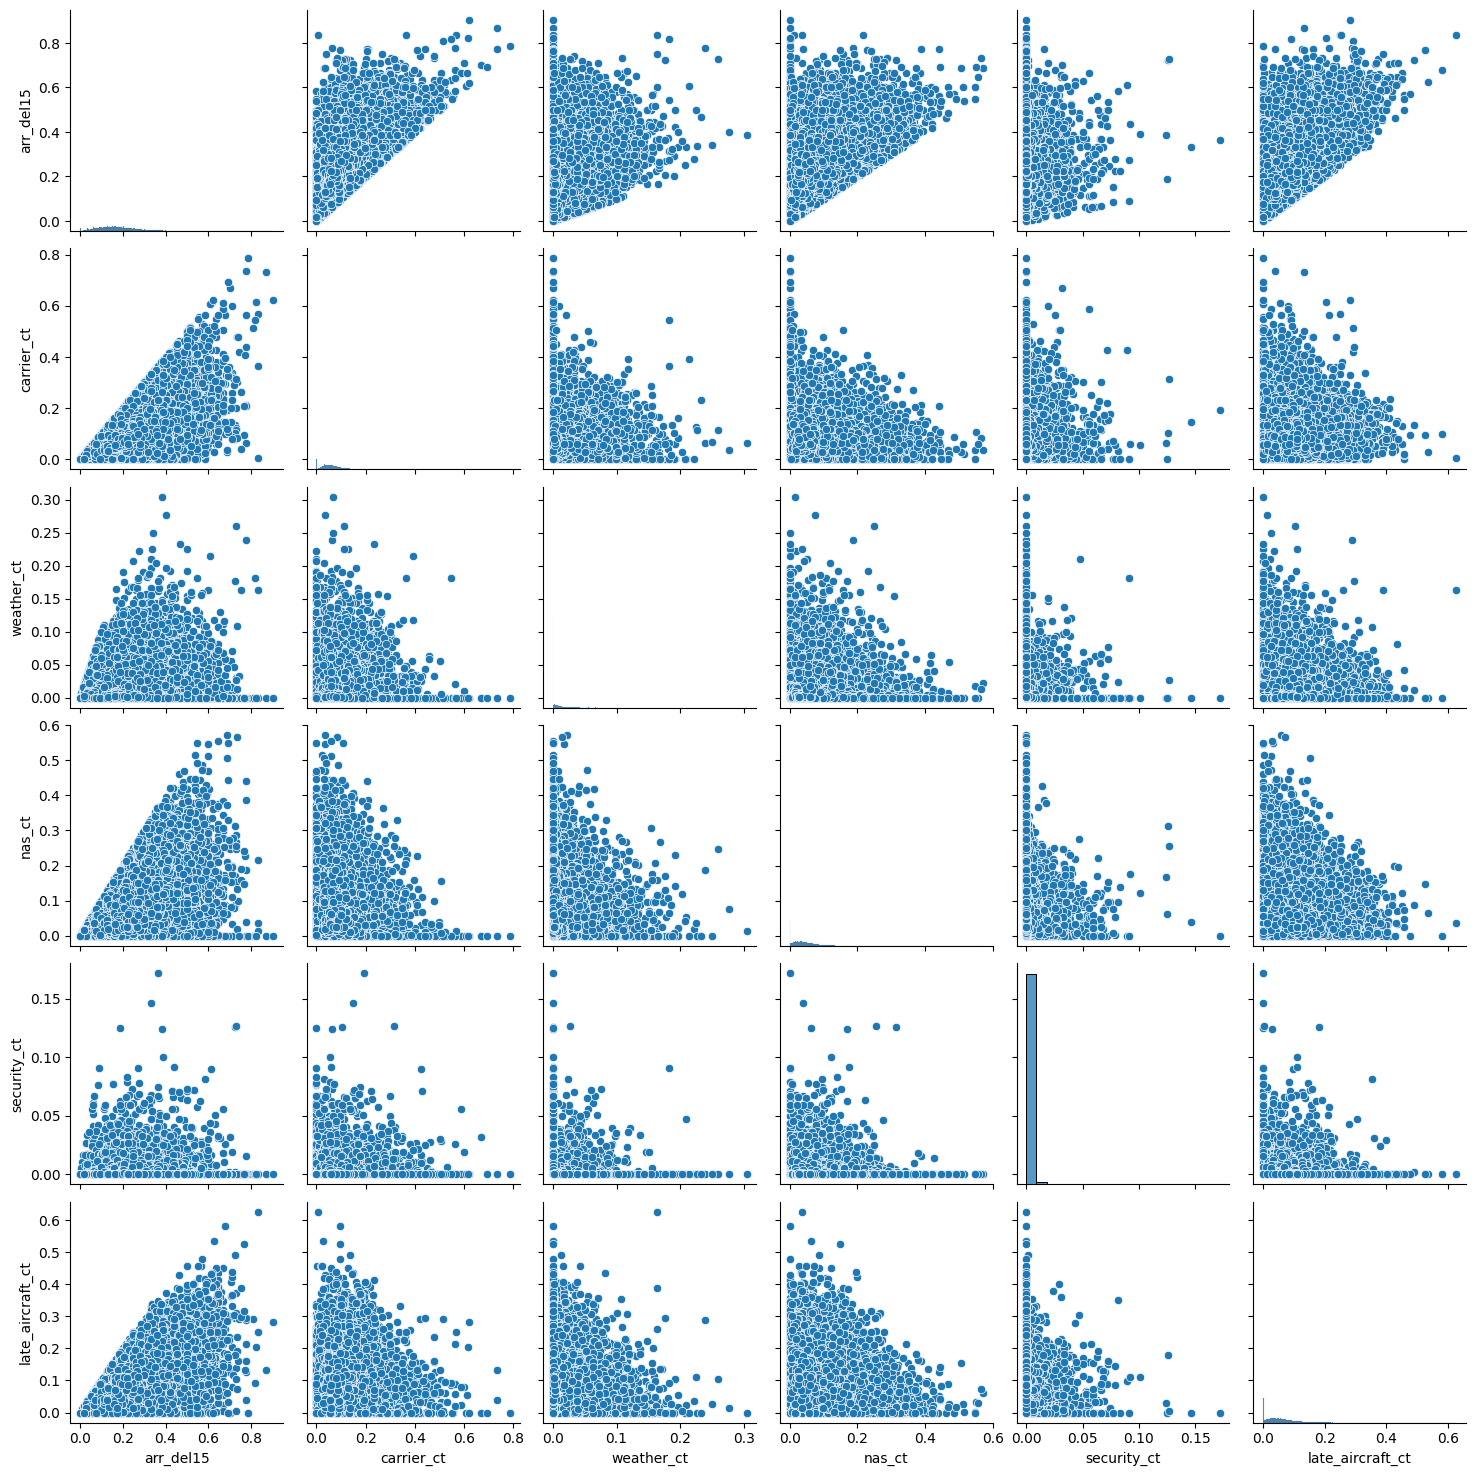

In [118]:
counts = dataNormalized.loc[:,'arr_del15':'late_aircraft_ct']
sns.pairplot(data=counts)

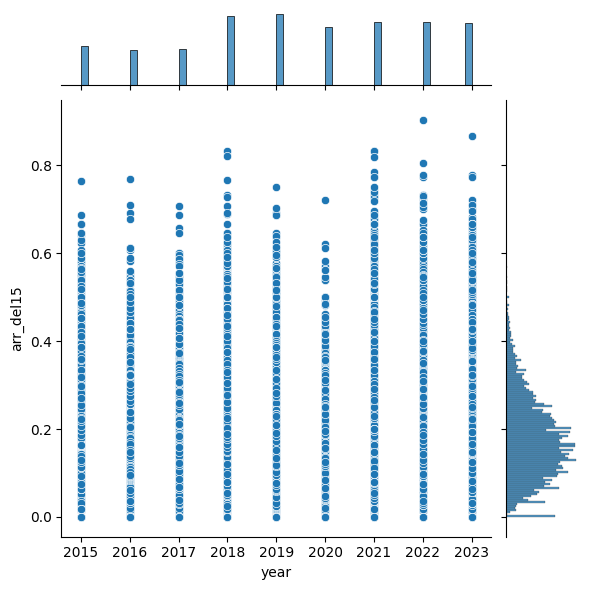

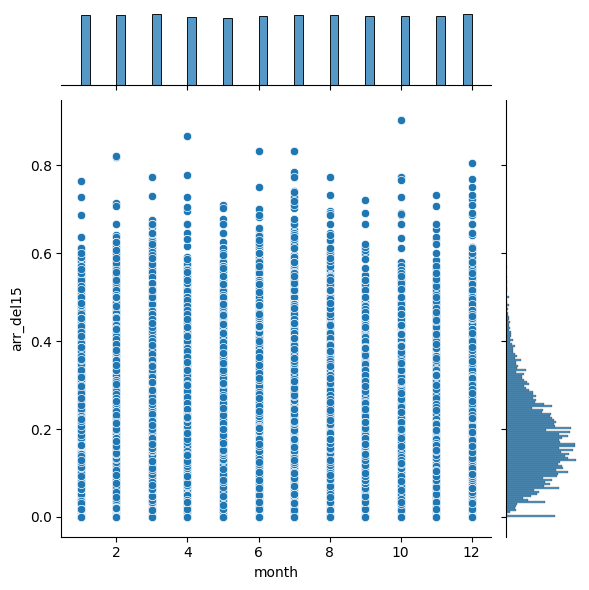

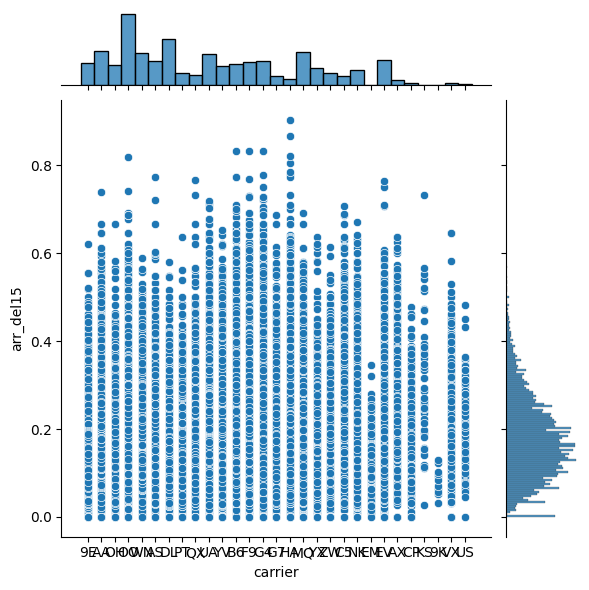

In [123]:
# fig, axs = plt.subplots(1,4)
sns.jointplot(data=dataNormalized, x='year',y='arr_del15')
sns.jointplot(data=dataNormalized, x='month',y='arr_del15')
sns.jointplot(data=dataNormalized, x='carrier',y='arr_del15')